<a href="https://colab.research.google.com/github/hansbrunner/epidemiology-analysis/blob/main/Framingham_Heart_Study/Framingham_Heart_Study_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Machine Learning approach to identify risk factors for CHD, in the Framingham Heart Study dataset
"""

In [40]:
import pandas as pd

# get data
df = pd.read_csv("framingham.csv")

# Impute or remove missing data
df = df.dropna()  # The simple way

# Create dummy variable for education
df = pd.get_dummies(df, columns=['education'], drop_first=True).astype(int)





In [17]:
# Start with feature selection
# Continuous variables
continuous_columns = ['age', 'totChol', 'BMI', 'sysBP', 'diaBP', 'cigsPerDay', 'heartRate', 'glucose']

# Binary variables
binary_columns = ['male', 'education_2.0', 'education_3.0', 'education_4.0'
                  ,'currentSmoker', 'BPMeds','prevalentStroke', 'prevalentHyp','diabetes']


In [41]:
# Feature selection of continuous varibles with ANOVA F-test
from sklearn.feature_selection import SelectKBest, f_classif

# Select features using ANOVA F-test
X_cont = df[continuous_columns]
y = df['TenYearCHD']

# Apply SelectKBest to extract the top features based on F-test
f_selector = SelectKBest(f_classif, k='all')
f_selector.fit(X_cont, y)

# Get F-scores and p-values
f_scores = f_selector.scores_
p_values = f_selector.pvalues_

# Create a DataFrame to show the results
f_test_results = pd.DataFrame({
    'Feature': continuous_columns,
    'F-Score': f_scores,
    'P-Value': p_values
})

# Sort the features by F-Score
f_test_results = f_test_results.sort_values(by='F-Score', ascending=False)
print(f_test_results)


      Feature     F-Score       P-Value
0         age  211.751448  1.122701e-46
3       sysBP  190.757964  2.468141e-42
4       diaBP   84.859849  5.261277e-20
6     glucose   55.228777  1.328790e-13
1     totChol   30.757290  3.131233e-08
2         BMI   26.230512  3.186426e-07
5  cigsPerDay    9.917900  1.649990e-03


In [42]:
# Feature selection of binary variables with Chi2
from sklearn.feature_selection import chi2

# Select binary variables
X_bin = df[binary_columns]

# Apply SelectKBest using chi2 for categorical variables
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_bin, y)

# Get chi2 scores and p-values
chi2_scores = chi2_selector.scores_
chi2_p_values = chi2_selector.pvalues_

# Create a DataFrame to show the results
chi2_results = pd.DataFrame({
    'Feature': binary_columns,
    'Chi2-Score': chi2_scores,
    'P-Value': chi2_p_values
})

# Sort the features by Chi2-Score
chi2_results = chi2_results.sort_values(by='Chi2-Score', ascending=False)
print(chi2_results)


           Feature  Chi2-Score       P-Value
6     prevalentHyp   82.845455  8.872601e-20
7         diabetes   31.067621  2.491938e-08
4           BPMeds   28.191569  1.098822e-07
0             male   17.107751  3.531788e-05
1    education_2.0    9.450345  2.111094e-03
5  prevalentStroke    8.507833  3.536210e-03
2    education_3.0    3.937698  4.721533e-02
3    education_4.0    0.356144  5.506558e-01


In [21]:
# Based on this initial feature selection, I decide to drop: currentSmoker and hearRate (not significant)
continuous_columns.remove("heartRate")
binary_columns.remove("currentSmoker")

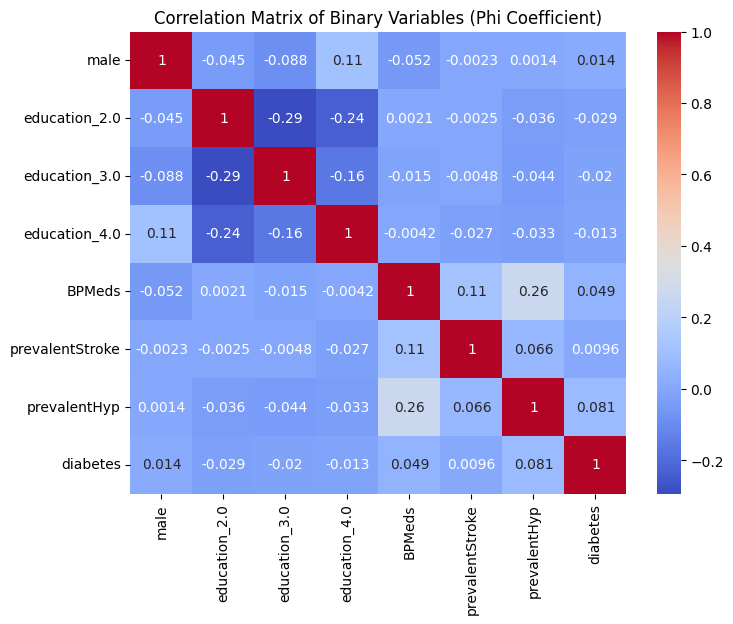

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

binary_vars = df[binary_columns]

# Compute the correlation matrix (Phi coefficient)
corr_matrix = binary_vars.corr()

# Plot the heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Binary Variables (Phi Coefficient)')
plt.show()


In [22]:
# Next, remove based on collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

print(continuous_columns)
# Select the remaining features
X = df[continuous_columns]

# Add a constant (intercept)
X = add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


['age', 'totChol', 'BMI', 'sysBP', 'diaBP', 'cigsPerDay', 'glucose']
     Variable         VIF
0       const  102.568507
1         age    1.307070
2     totChol    1.100894
3         BMI    1.188993
4       sysBP    3.088332
5       diaBP    2.855993
6  cigsPerDay    1.042854
7     glucose    1.031215


15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


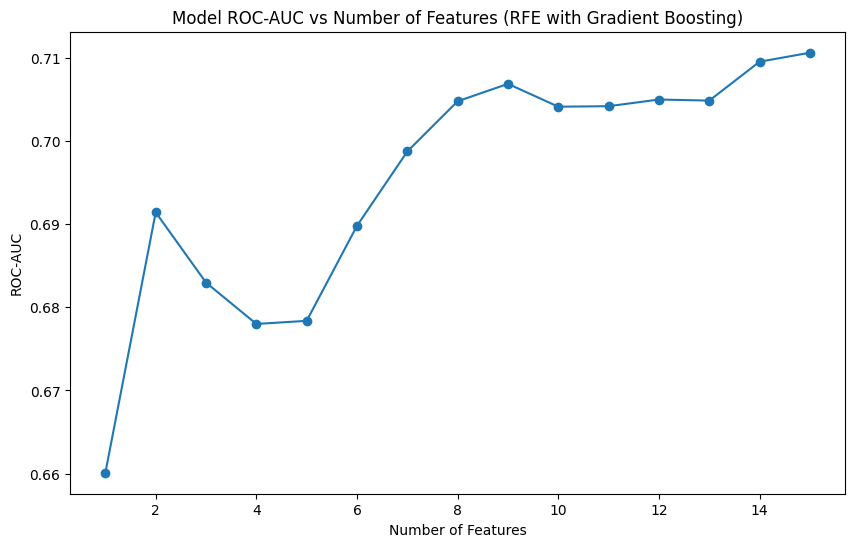

In [31]:
# Recursive Feature Elimination using Gradient Boosting. Hyperparameter tuning will come later
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalized continuous variables
model_df = df.copy()
model_df[continuous_columns] = StandardScaler().fit_transform(model_df[continuous_columns])

X = model_df[binary_columns+continuous_columns]
y = df["TenYearCHD"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

# Initialize RFE with the model
rfe = RFE(estimator=model, n_features_to_select=1, step=1)  # Start with all features, remove one at a time

# Track ROC AUC
n_features = X_train.shape[1]
roc_auc_scores = []

# Fit RFE
for i in range(n_features, 0, -1):
    print(i)
    rfe.n_features_to_select = i
    rfe.fit(X_train, y_train)
    y_pred_proba = rfe.predict_proba(X_test)[:, 1]  # Predict probabilities for ROC-AUC

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_auc_scores.append(roc_auc)

# Plot the number of features vs ROC AUC
plt.figure(figsize=(10, 6))
plt.plot(range(n_features, 0, -1), roc_auc_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('ROC-AUC')
plt.title('Model ROC-AUC vs Number of Features (RFE with Gradient Boosting)')
plt.show()


In [36]:
# Show rankings from RFE
ranking = rfe.ranking_
features_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X is the original DataFrame with feature names
    'Rank': ranking
})
# Sort the DataFrame by ranking (lower rank is more important)
features_df = features_df.sort_values(by='Rank')

# Display the ordered features
print(features_df)
# Based on this, and the plot, I discard 4 features: education, prevalentHyp,BPMeds,diabetes
# This is interesting based on previous results, that especially BPMeds, prevalentHyp and diabetes where highly correlated with CHD.
# This suggest that these features carry redundant information, i.e. the predictive power is low.
# These variables might be redundant to age, glucose, and blood pressure.

#continuous_columns.([])
#binary_columns.remove([])

            Feature  Rank
11            sysBP     1
8               age     2
14          glucose     3
12            diaBP     4
10              BMI     5
9           totChol     6
13       cigsPerDay     7
0              male     8
5   prevalentStroke     9
1     education_2.0    10
6      prevalentHyp    11
4            BPMeds    12
7          diabetes    13
2     education_3.0    14
3     education_4.0    15
